In [11]:
from music21 import *
import copy

In [27]:
def mutate_melody(melody: stream.Part(), tonic: pitch.Pitch, key):
    '''
    given a melody, change it as appropriate. then return that melody.
    '''
    staccato_short(melody, 0.9)
    accent_downbeat(melody)
    elevate_repeats(melody, tonic)
    chord_it(melody, tonic)
    grace_beginners(melody, tonic)

# Helper Functions

They will help us for some basic tasks.

In [ ]:
def note_without_octave(n: note.Note) -> str:
    '''
    given a note, 
    '''

In [ ]:
def next_note_up(n: note.Note, tonic. pitch.Pitch) -> note.Note:
    '''
    given a note in a scale, find the next note that's one higher.
    '''
    

# Modifications to Melody

They are all intentionally short, and meant to be modular--that is, they can build on top of each other without causing much trouble.

## Articulation Modifications

In [12]:
def staccato_short(melody: stream.Part(), min_dur: float):
    '''
    make all sufficiently-short notes in the melody staccato.
    '''
    for n in melody[note.Note]:
        if n.quarterLength <= min_dur:
            n.articulations += [articulations.Staccato()]

In [13]:
def grace_beginners(melody: stream.Part(), tonic: pitch.Pitch, offset_mult=4):
    '''
    given a melody, add a grace note to notes which have the desired offset
    multiplier (default 4; grace at 0, 4, 8, etc.)
    
    This method is to be called last!
    '''
    sc = scale.MajorScale(tonic.name)
    
    for n in melody[note.Note]:
        if n.offset % offset_mult == 0:
            grace_start = note.Note(sc.nextPitch(n.nameWithOctave))
            grace = grace_start.getGrace()
            melody.insert(n.offset, grace)

In [14]:
def accent_downbeat(melody: stream.Part()):
    '''
    given a melody, accent every downbeat of the measures of the melody.
    '''
    for n in melody[note.Note]:
        n.articulations += [articulations.Accent()]

In [15]:
n = note.Note('G4')
n
melody = stream.Part()
melody.append(n)
accent_downbeat(melody)
grace_beginners(melody, pitch.Pitch('C4'))
for no in melody[note.Note]:
    print(no)

<music21.note.Note A>
<music21.note.Note G>


In [16]:
sc = scale.MajorScale('A')
sc.nextPitch(note.Note('F4').nameWithOctave)

<music21.pitch.Pitch F#4>

## Involvement

The melody gets thicker...or less so.

In [17]:
def double_note_frequency(melody: stream.Part(), tonic: pitch.Pitch) -> stream.Part():
    '''
    given a melody, change each note to have two notes, each with double the frequency
    '''
    
    newm = stream.Part()
    for n in melody[note.Note]:
        n1 = copy.deepcopy(n)
        n2 = copy.deepcopy(n1)
        
        n1.quarterLength = n.quarterLength * 0.5
        #this will modify both of them correctly
        
        #delete note n
        #add to that place: n1, n2 sequentially
        newm.append(n1)
        newm.append(n2)
    
    return newm

In [18]:
# test double_note_frequency
melody = stream.Part()
melody.append(note.Note('G4'))
melody.append(note.Note('G#4'))

newm = double_note_frequency(melody, pitch.Pitch('G4'))
for n in newm[note.Note]:
    print(n, n.offset)

<music21.note.Note G> 0.0
<music21.note.Note G> 0.5
<music21.note.Note G#> 1.5
<music21.note.Note G#> 2.0


In [19]:
def elevate_repeats(melody: stream.Part(), tonic: pitch.Pitch, offset_mult=4):
    '''
    given a melody, for every note which starts a measure or a given offset
    multiplier (default 4: start of a 4/4 measure), change that note
    to have the next note up for the last 1/4 duration.
    
    Inspired by Country Gardens.
    
    C(4)-C(4) becomes C(3)-D(1)-C(4); parentheses illustrate durations.
    '''
    
    sc = scale.MajorScale(tonic.name)
    
    for n in melody[note.Note]:
        if n.offset % offset_mult == 0:
            dur = n.quarterLength
            n.quarterLength = 0.75 * dur
            add_note = note.Note(sc.nextPitch(n.nameWithOctave))
            add_note.quarterLength = 0.25 * dur
            melody.insert(n.offset + 0.75*dur, add_note)

In [20]:
melody = stream.Part()
melody.append(note.Note('G4'))
melody.append(note.Note('G4'))
melody.append(note.Note('G4'))
melody.append(note.Note('G4'))
melody.append(note.Note('G4'))
print(note.Note('G4').quarterLength)
melody
elevate_repeats(melody, pitch.Pitch('C4'))
for no in melody[note.Note]:
    print(no, no.offset)

1.0
<music21.note.Note G> 0.0
<music21.note.Note A> 0.75
<music21.note.Note G> 1.0
<music21.note.Note G> 2.0
<music21.note.Note G> 3.0
<music21.note.Note G> 4.0
<music21.note.Note A> 4.75


## Stacking

Keep the same notes, but thicken them.

In [21]:
def chord_it(melody: stream.Part(), tonic: pitch.Pitch, is_above=False, offset_mult=4):
    '''
    given a melody, take the first note of each measure and turn that into a chord
    '''
    sc = scale.MajorScale(tonic.name)
    
    for n in melody[note.Note]:
        chord_notes = []
        if n.offset % offset_mult == 0:
            pitch_nums = [2, 4, 7]
            for i in range(3):
                new_note = note.Note(sc.nextPitch(n.nameWithOctave, stepSize=pitch_nums[i]).nameWithOctave)
                new_note.quarterLength = n.quarterLength
                if not is_above:
                    new_note.octave -= 1 if new_note.name != n.name else 2
                chord_notes.append(new_note)
            new_chord = chord.Chord(chord_notes)
            melody.insert(n.offset, new_chord)

In [22]:
chord_it(melody, pitch.Pitch('C4'))

for no in melody[chord.Chord]:
    print(no, no.pitches, no.offset)

melody.show('midi')

<music21.chord.Chord B3 D4 G3> (<music21.pitch.Pitch B3>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch G3>) 0.0
<music21.chord.Chord B3 D4 G3> (<music21.pitch.Pitch B3>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch G3>) 4.0


In [23]:
n = note.Note('G6')

p = pitch.Pitch('G6')

p.octave

6

# Scaling the Hierarchy

Becuse parts cannot simply be concatenated to each other, we will need a few helper functions.

In [24]:
import copy

melody = stream.Part()
melody.append(note.Note('G4'))
melody.append(note.Note('F4'))

melody2 = stream.Part()
melody2.append(note.Note('G43'))
melody2.append(note.Note('F43'))

melody3 = melody + melody2

for n in melody3[note.Note]:
    print(n, n.octave, n.offset)

<music21.note.Note G> 4 0.0
<music21.note.Note G> 43 0.0
<music21.note.Note F> 4 1.0
<music21.note.Note F> 43 1.0


# Testing

We will test our function on pieces of different genres and see how they compare.

In [30]:
# primary test: Bach!

bach = corpus.parse('bwv66.6')

bach_melody = bach[1]

tonic = pitch.Pitch('A4')

changed_melody = mutate_melody(bach_melody, tonic, bach.keySignature)

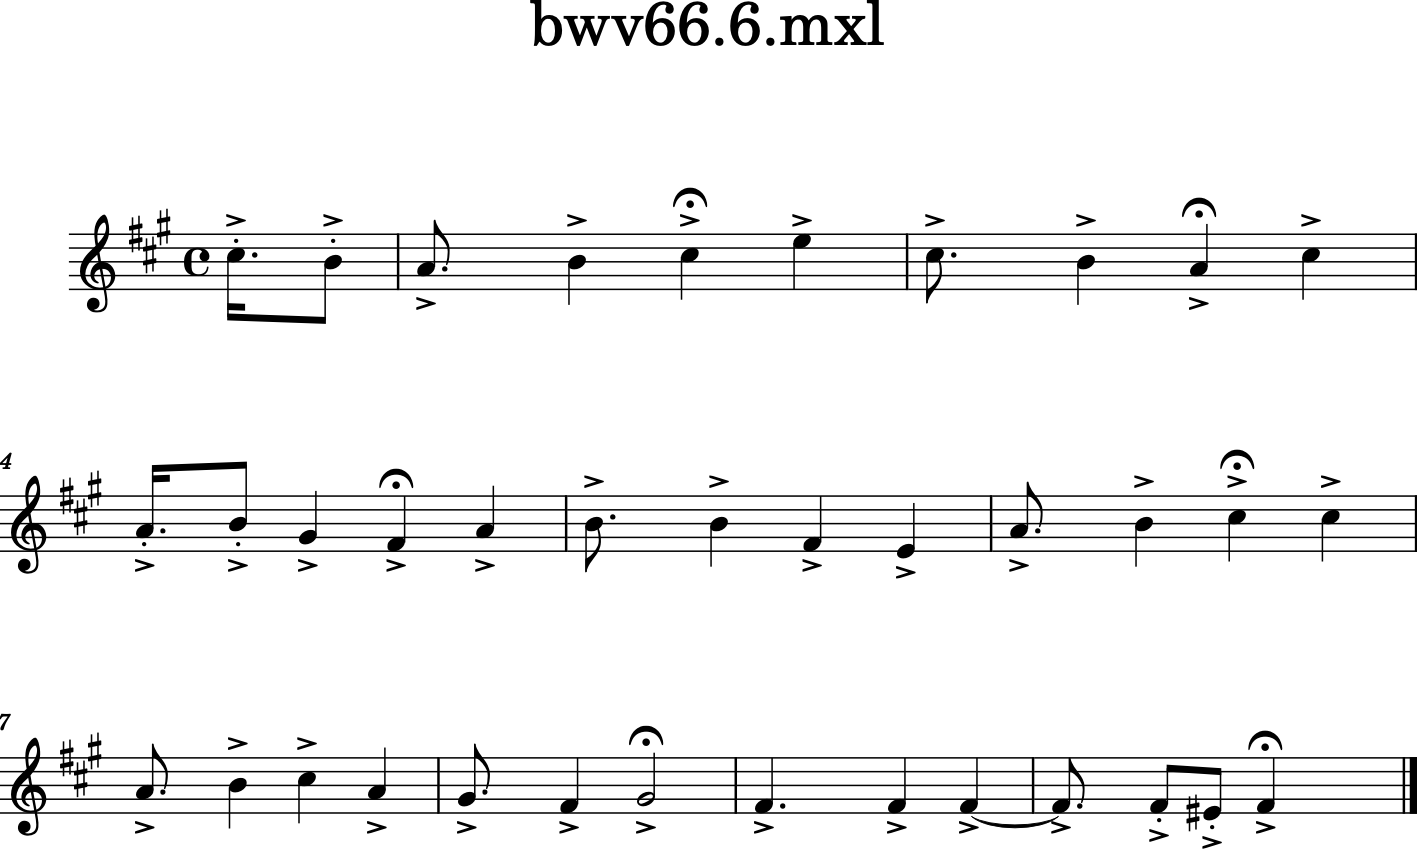

In [31]:
bach_melody.show()